<a href="https://colab.research.google.com/github/YoonSungLee/AI-Innovation-Square_Vision/blob/master/Day%2019_U-Net%20Softmax%20activation%20%EC%8B%A4%EC%8A%B5/Mnet_tutorial_softmax2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical


import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    # (20, 256, 256)
    # batch_y = np.expand_dims(batch_y,3)
    # (20, 256, 256, 1)

    batch_y = to_categorical(batch_y)
    # (20, 256, 256) --> (20, 256, 256, 2)

  
    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 4

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

In [0]:
print (x.shape, y.shape)

(4, 256, 256, 3) (4, 256, 256, 2)


(256, 256, 3) (256, 256, 3)


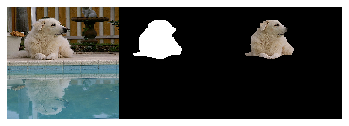

In [0]:
plt.axis('off')
img = x[0]
# img (256, 256, 3)
msk = y[0]
# mask (256, 256, 2)
msk = msk[:,:,1]
# msk[:,:,0] --> 배경이 1, 물체가 0
# msk[:,:,1] --> 배경이 0, 물체가 1
# msk (256, 256)

# (256, 256, 3) * (256, 256, 3) = (256, 256, 3)

msk = np.stack((msk,)*3, axis=-1)

print (img.shape, msk.shape)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  # x = Input(batch_shape=(32, 256, 256, 3))
  inputs = x
  
  #Contracting layers
  nKernels = 4
  layers = []

  # Level 2 (128, 128, 3)
  L_Reg_1 = MaxPooling2D()(x)
  # Level 3 (64, 64, 3)
  L_Reg_2 = MaxPooling2D()(L_Reg_1)
  # Leve 4 (32, 32, 3)
  L_Reg_3 = MaxPooling2D()(L_Reg_2)
  # Level 5 (16, 16, 3)
  L_Reg_4 = MaxPooling2D()(L_Reg_3) 
  # Level 6  (8, 8, 3)
  L_Reg_5 = MaxPooling2D()(L_Reg_4)
  # BottleNeck  (4, 4, 3)
  L_Reg_6 = MaxPooling2D()(L_Reg_5)

  # level_1 (256, 256, 8)
  # level+layer
  layer11 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (x)
  layer11 = BatchNormalization()(layer11)
  layer12 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer11)
  layer12 = BatchNormalization()(layer12)
  layers.append(layer12)
  layer13 = MaxPooling2D() (layer12)
  
  # level_2 (128, 128, 16)
  # layer13 (128, 128, 16), (128, 128, 3)  --> (128, 128, 19)
  layer13 = Concatenate(axis=3)([L_Reg_1, layer13])
  layer21 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer13)
  layer21 = BatchNormalization()(layer21)
  layer22 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer21)
  layer22 = BatchNormalization()(layer22)
  layers.append(layer22)
  layer23 = MaxPooling2D() (layer22)

  # level_3 (64, 64, 32)
  # layer23 (64, 64, 32) (64, 64, 3)  --> (64, 64, 35)
  layer23 = Concatenate(axis=3)([L_Reg_2, layer23])
  layer31 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer23)
  layer31 = BatchNormalization()(layer31)
  layer32 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer31)
  layer32 = BatchNormalization()(layer32)
  layers.append(layer32)
  layer33 = MaxPooling2D() (layer32)

  # level_4 (32, 32, 64)
  layer33 = Concatenate(axis=3)([L_Reg_3, layer33])
  layer41 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer33)
  layer41 = BatchNormalization()(layer41)
  layer42 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer41)
  layer42 = BatchNormalization()(layer42)
  layers.append(layer42)
  layer43 = MaxPooling2D() (layer42)

  # level_5 (16, 16, 128)
  layer43 = Concatenate(axis=3)([L_Reg_4, layer43])
  layer51 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer43)
  layer51 = BatchNormalization()(layer51)
  layer52 = Conv2D(nKernels*32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer51)
  layer52 = BatchNormalization()(layer52)
  layers.append(layer52)
  layer53 = MaxPooling2D() (layer52)

  # level_6 (8, 8, 256)
  layer53 = Concatenate(axis=3)([L_Reg_5, layer53])
  layer61 = Conv2D(nKernels*32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer53)
  layer61 = BatchNormalization()(layer61)
  layer62 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer61)
  layer62 = BatchNormalization()(layer62)
  layers.append(layer62)
  layer63 = MaxPooling2D() (layer62)
  
  # BottleNeck (4, 4, 512)
  layer63 = Concatenate(axis=3)([L_Reg_6, layer63])
  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer63)
  bottleneck11 = BatchNormalization()(bottleneck11)
  bottleneck12 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (bottleneck11)
  bottleneck12 = BatchNormalization()(bottleneck12)
  R_leg_6 = bottleneck12
  bottleneck13 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (bottleneck12)
  # (8, 8, 256)
  level = len(layers) - 1
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]])
  
  
  # level 7 = level 6
  layer72 = Conv2D(nKernels*32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer71)
  layer72 = BatchNormalization()(layer72)
  layer73 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer72)
  layer73 = BatchNormalization()(layer73)
  R_leg_5 = layer73
  layer74 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer73)
  level = len(layers) - 2
  layer81 = Concatenate(axis=3)([layer74, layers[level]])
  R_leg_6 = UpSampling2D()(R_leg_6)
  R_leg_5 = Concatenate(axis=3)([R_leg_6, R_leg_5])

  
  # level 8 = level 5
  layer82 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer81)
  layer82 = BatchNormalization()(layer82)
  layer83 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal',  padding='same') (layer82)
  layer83 = BatchNormalization()(layer83)
  R_leg_4 = layer83
  layer84 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer83)
  level = len(layers) - 3
  layer91 = Concatenate(axis=3)([layer84, layers[level]])
  R_leg_5 = UpSampling2D()(R_leg_5)
  R_leg_4 = Concatenate(axis=3)([R_leg_4, R_leg_5])

  # level 9 = level 4
  layer92 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer91)
  layer92 = BatchNormalization()(layer92)
  layer93 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer92)
  layer93 = BatchNormalization()(layer93)
  R_leg_3 = layer93
  layer94 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (layer93)
  level = len(layers) - 4
  layer101 = Concatenate(axis=3)([layer94, layers[level]])
  R_leg_4 = UpSampling2D()(R_leg_4)
  R_leg_3 = Concatenate(axis=3)([R_leg_3, R_leg_4])

  # level 10 = level 3
  layer102 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal',  padding='same') (layer101)
  layer102 = BatchNormalization()(layer102)
  layer103 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal',  padding='same') (layer102)
  layer103 = BatchNormalization()(layer103)
  R_leg_2 = layer103
  layer104 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer103)
  level = len(layers) - 5
  layer111 = Concatenate(axis=3)([layer104, layers[level]])
  R_leg_3 = UpSampling2D()(R_leg_3)
  R_leg_2 = Concatenate(axis=3)([R_leg_2, R_leg_3])
  
  # level 11 = level 2
  layer112 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer111)
  layer112 = BatchNormalization()(layer112)
  layer113 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer112)
  layer113 = BatchNormalization()(layer113)
  R_leg_1 = layer113
  print (R_leg_1)
  layer114 = Conv2DTranspose(nKernels, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer113)
  level = len(layers) - 6
  layer121 = Concatenate(axis=3)([layer114, layers[level]])
  R_leg_2 = UpSampling2D()(R_leg_2)
  R_leg_1 = Concatenate(axis=3)([R_leg_1, R_leg_2])
      
  #level 1 = classification 
  R_leg_0 = UpSampling2D()(R_leg_1)
  layer121 = Concatenate(axis=3)([layer121, R_leg_0])
  classification1 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer121)
  classification1 = Dropout(0.25)(classification1)
  classification2 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (classification1)
  outputs = Conv2D(2, 1, activation='softmax') (classification2)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [dice_coef])
  
  return model

In [0]:
model = unet()

Tensor("batch_normalization_239/cond/Merge:0", shape=(?, 128, 128, 8), dtype=float32)


In [0]:
model.summary()

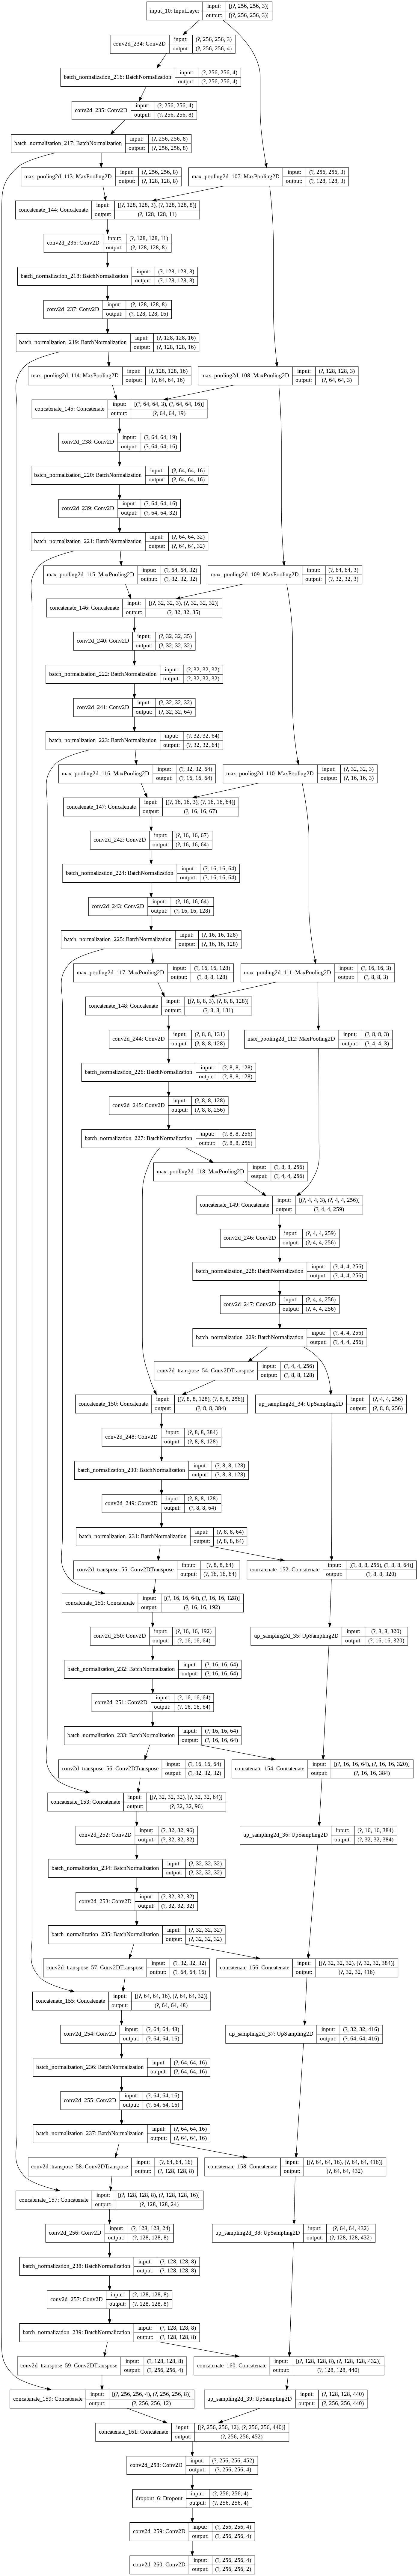

In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        # input --> (1, 256,256, 3)
        # shape of pred --> (1, 256, 256, 2)
        
        msk = np.argmax(pred, axis=-1)
        # (1, 256, 256, 2) -> (1, 256, 256)
        msk  = msk.squeeze()
        # (1, 256, 256) --> (256, 256)
        msk = np.stack((msk,)*3, axis=-1)
        # (256, 256) --> (256, 256, 3)

        #mask post-processing 
        # msk  = pred.squeeze()
        # msk = np.stack((msk,)*3, axis=-1)
        # msk[msk >= 0.5] = 1 
        # msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print (train_steps, test_steps)

1755 92


i= 1 loss= 0.6807944785920303 val_loss= 0.50861314230639 mean_dsc= 0.68408203 val_mean_dsc= 0.80273867


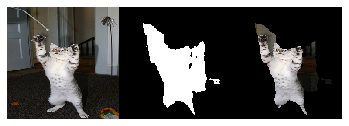

i= 2 loss= 0.423458038818123 val_loss= 0.4517000202575456 mean_dsc= 0.8250979 val_mean_dsc= 0.80836576


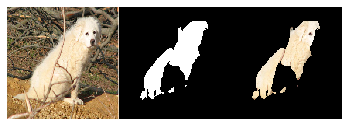

i= 3 loss= 0.36110114717585406 val_loss= 0.3367155173226543 mean_dsc= 0.854089 val_mean_dsc= 0.8643127


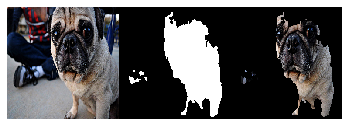

i= 4 loss= 0.3291295950696339 val_loss= 0.3513939474587855 mean_dsc= 0.8651205 val_mean_dsc= 0.8669328


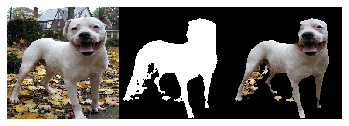

i= 5 loss= 0.2959206480543498 val_loss= 0.3345882207479166 mean_dsc= 0.8789076 val_mean_dsc= 0.86260116


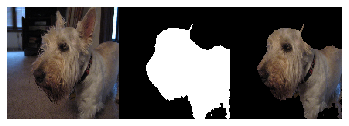

i= 6 loss= 0.27819008658669275 val_loss= 0.31853997561594716 mean_dsc= 0.8875153 val_mean_dsc= 0.8768944


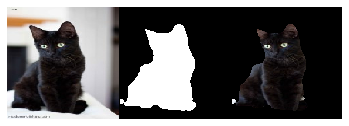

i= 7 loss= 0.256491923561463 val_loss= 0.37349859552214976 mean_dsc= 0.8959346 val_mean_dsc= 0.85171443


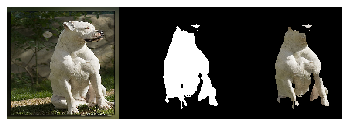

i= 8 loss= 0.24286036150917367 val_loss= 0.2988340618169826 mean_dsc= 0.900876 val_mean_dsc= 0.8805911


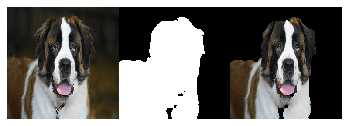

i= 9 loss= 0.22795388377205258 val_loss= 0.3206380665626215 mean_dsc= 0.90631425 val_mean_dsc= 0.8789294


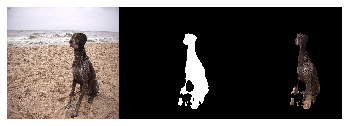

i= 10 loss= 0.21811752964203854 val_loss= 0.3394336597589047 mean_dsc= 0.9104961 val_mean_dsc= 0.8782348


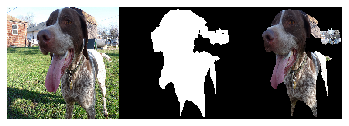

i= 11 loss= 0.2108944105626511 val_loss= 0.2980352601279383 mean_dsc= 0.9138117 val_mean_dsc= 0.8898135


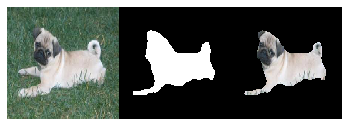

i= 12 loss= 0.19958673235018368 val_loss= 0.29341071301504323 mean_dsc= 0.91774684 val_mean_dsc= 0.88602066


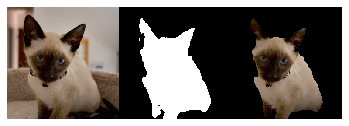

In [0]:
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [0]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-03-07 15:54:56--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.226.15.41, 13.226.15.118, 13.226.15.105, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.226.15.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.005s  

2020-03-07 15:54:56 (12.0 MB/s) - ‘test.jpg’ saved [63219/63219]



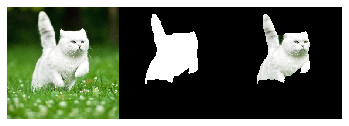

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
# msk  = pred.squeeze()
# msk = np.stack((msk,)*3, axis=-1)
# msk[msk >= 0.5] = 1 
# msk[msk < 0.5] = 0 

msk = np.argmax(pred, axis=-1)
# (1, 256, 256)
msk  = msk.squeeze()
# (256, 256)
msk = np.stack((msk,)*3, axis=-1)
# (256, 256, 3)

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

